## Angular Response function for LISA


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import spherharm
from pypack import detectors as det

In [85]:
L = 2.5e9 # [km]
c = 3e8 # [km/s]
f_star = c/2/np.pi/L # [Hz]

In [86]:
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

In [87]:
def e_plus(Theta_mesh,Phi_mesh):
    v = np.array([np.sin(Phi_mesh), -np.cos(Phi_mesh), np.zeros_like(Theta_mesh)])
    u = np.array([np.cos(Phi_mesh) * np.cos(Theta_mesh),np.sin(Phi_mesh) * np.cos(Theta_mesh),-np.sin(Theta_mesh)])
    return (np.einsum('i...,k...',u,u)-np.einsum('i...,k...',v,v))

def e_cross(Theta_mesh,Phi_mesh):
    v = np.array([np.sin(Phi_mesh), -np.cos(Phi_mesh), np.zeros_like(Theta_mesh)])
    u = np.array([np.cos(Phi_mesh) * np.cos(Theta_mesh),np.sin(Phi_mesh) * np.cos(Theta_mesh),-np.sin(Theta_mesh)])
    return (np.einsum('i...,k...',u,v)+np.einsum('i...,k...',v,u))

ortogonality condition.

In [88]:
Theta_vec = np.linspace(0,np.pi,100)
Phi_vec = np.linspace(0,2*np.pi,1)
Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
Omega = np.round(np.array([np.cos(Phi_mesh)*np.sin(Theta_mesh),np.sin(Phi_mesh)*np.sin(Theta_mesh),np.cos(Theta_mesh)]),20)
# Verify the orthogonality condition
print(np.einsum('lmij,lmij->lm',e_cross(Theta_mesh,Phi_mesh),e_cross(Theta_mesh,Phi_mesh)))
print(np.einsum('lmij,lmij->lm',e_plus(Theta_mesh,Phi_mesh),e_plus(Theta_mesh,Phi_mesh)))
print(np.einsum('lmij,lmij->lm',e_cross(Theta_mesh,Phi_mesh),e_plus(Theta_mesh,Phi_mesh)))

[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


## LISA Response function



In [89]:
def Evaluate_Product(l_vec,Theta_mesh,Phi_mesh,tensor):
    if tensor == 'plus':
        e_values = e_plus(Theta_mesh,Phi_mesh)
    elif tensor == 'cross':
        e_values = e_cross(Theta_mesh,Phi_mesh)
    result = np.einsum('i,j,lmij', l_vec,l_vec, e_values) # [n_Phi, n_Theta]
    return result
    

Transfer function.
\begin{equation*}
\mathcal{T}(f,\hat{l}_{AB},\hat{n})=\frac{1}{2}\left[e^{ -\pi i f L (1+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1+\hat{k}\cdot \hat{l}_{AB})\right)+ e^{ -\pi i f L (3+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1-\hat{k}\cdot \hat{l}_{AB})\right)\right]
\end{equation*}



In [90]:
# Build the transfer function
def F_cal (l,Omega,f_vec,f_star):
    inner = np.einsum('i,ijk',l,Omega)
    return 1/2 * (  np.sinc(f_vec/2/np.pi/f_star * (1-inner)) * np.exp(-1j*f_vec/2/f_star * (3+inner))\
                                    + np.sinc(f_vec/2/np.pi/f_star * (1+inner)) * np.exp(-1j*f_vec/2/f_star * (1+inner)))

In [91]:
print(3e8/(2*np.pi*2.5e9))

0.019098593171027443


Check $\mathcal{T} (f\ll f_*) = 1$. 

In [92]:
f_vec_try = np.logspace(-5,-3,200)
print(np.real(F_cal(lBA,Omega,np.expand_dims(f_vec_try,axis=(1,2)),f_star)))

[[[0.99999982 0.99999982 0.99999981 ... 0.99999981 0.99999982 0.99999982]]

 [[0.99999981 0.99999981 0.9999998  ... 0.9999998  0.99999981 0.99999981]]

 [[0.9999998  0.9999998  0.99999979 ... 0.99999979 0.9999998  0.9999998 ]]

 ...

 [[0.99833472 0.9983148  0.9982947  ... 0.9982947  0.9983148  0.99833472]]

 [[0.99825587 0.99823501 0.99821396 ... 0.99821396 0.99823501 0.99825587]]

 [[0.9981733  0.99815145 0.9981294  ... 0.9981294  0.99815145 0.9981733 ]]]


In [94]:
f_vec_LIGO = np.logspace(1,3,200)
f_star = 3e8/(2*np.pi*4e3)
print(np.real(F_cal(e1H,Omega,np.expand_dims(f_vec_LIGO,axis=(1,2)),f_star)))

[[[0.9999993  0.9999993  0.99999931 ... 0.99999969 0.99999969 0.99999969]]

 [[0.99999927 0.99999927 0.99999927 ... 0.99999968 0.99999968 0.99999968]]

 [[0.99999923 0.99999924 0.99999924 ... 0.99999966 0.99999966 0.99999966]]

 ...

 [[0.99363232 0.99366457 0.99369911 ... 0.99721514 0.99720271 0.99718905]]

 [[0.99333116 0.99336494 0.99340111 ... 0.99708339 0.99707037 0.99705607]]

 [[0.99301579 0.99305116 0.99308904 ... 0.99694542 0.99693178 0.9969168 ]]]


### Step 3


\begin{equation*}
    \mathcal{R}_{AA'}(f) = \int \frac{d\Omega_{\vec {k}}}{4 \pi} \left[ \mathcal{R}_A^+(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^+}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n}) + \mathcal{R}_A^{\times}(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^{\times}}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n})\right]\,,
\end{equation*}
with
\begin{equation*}
\mathcal{R}_A^P(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}) = \frac{1}{2} e^{-i2\pi f \hat{n}\cdot\vec{x}_A/c} \left[\mathcal{T}(f,\hat{l}_{AB},\hat{n})-\mathcal{T}(f,\hat{l}_{AC},\hat{n})  \right]
\end{equation*}



In [113]:
def F_det (l1,l2,Theta_mesh,Phi_mesh,f_vec,f_star,x_det):
    Omega = np.round(np.array([np.cos(Phi_mesh)*np.sin(Theta_mesh),np.sin(Phi_mesh)*np.sin(Theta_mesh),np.cos(Theta_mesh)]),20)
    f_exp = np.expand_dims(f_vec, axis=(1,2))
    F_1 = F_cal(l1,Omega,f_exp,f_star)
    F_2 = F_cal(l2,Omega,f_exp,f_star)
    return 1/2 * np.exp(-1j* f_exp/f_star * np.einsum('i,ijk',x_det,Omega)) \
            * (+ F_1 * Evaluate_Product(l1,Theta_mesh,Phi_mesh,'plus')\
               - F_2 * Evaluate_Product(l2,Theta_mesh,Phi_mesh,'plus')),\
            1/2 * np.exp(-1j* f_exp/f_star * np.einsum('i,ijk',x_det,Omega)) \
            * (+ F_1 * Evaluate_Product(l1,Theta_mesh,Phi_mesh,'cross')\
               - F_2 * Evaluate_Product(l2,Theta_mesh,Phi_mesh,'cross')),

def Response(l_det1,l_det2,x_det1,x_det2,f_vec,f_star):
    Theta_vec = np.linspace(0,np.pi,100)
    Phi_vec = np.linspace(0,2*np.pi,100)
    Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
    F1_p, F1_c = F_det(l_det1[0],l_det1[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det1)
    F2_p, F2_c = F_det(l_det2[0],l_det2[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det2)
    R_integrand = F1_p  * np.conj(F2_p) \
                + F1_c * np.conj(F2_c)
    R1 = np.trapz(R_integrand,Phi_vec,axis=1)
    R = np.real(np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1))*1/4/np.pi
    return R

#tinto
#Saito

[-0.89058124 -0.89058122 -0.89058119 -0.89058116 -0.89058112 -0.89058108
 -0.89058104 -0.890581   -0.89058095 -0.89058089 -0.89058083 -0.89058077
 -0.89058069 -0.89058061 -0.89058053 -0.89058043 -0.89058033 -0.89058021
 -0.89058009 -0.89057995 -0.89057979 -0.89057963 -0.89057944 -0.89057924
 -0.89057902 -0.89057878 -0.89057851 -0.89057822 -0.8905779  -0.89057755
 -0.89057716 -0.89057674 -0.89057627 -0.89057576 -0.8905752  -0.89057459
 -0.89057391 -0.89057317 -0.89057236 -0.89057147 -0.89057049 -0.89056941
 -0.89056823 -0.89056694 -0.89056552 -0.89056396 -0.89056225 -0.89056037
 -0.89055831 -0.89055605 -0.89055356 -0.89055084 -0.89054785 -0.89054457
 -0.89054096 -0.89053701 -0.89053267 -0.89052791 -0.89052269 -0.89051695
 -0.89051066 -0.89050375 -0.89049617 -0.89048785 -0.89047872 -0.8904687
 -0.8904577  -0.89044563 -0.89043238 -0.89041784 -0.89040188 -0.89038437
 -0.89036515 -0.89034406 -0.89032091 -0.89029551 -0.89026763 -0.89023703
 -0.89020345 -0.8901666  -0.89012615 -0.89008177 -0.

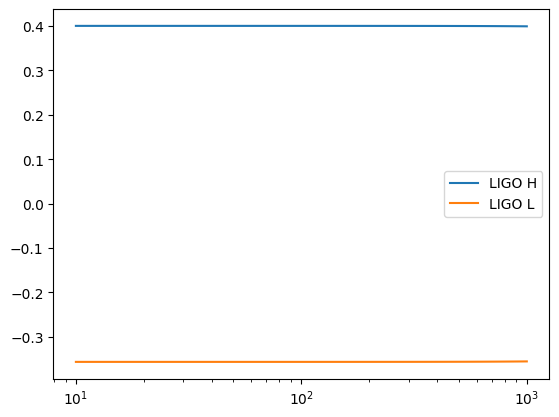

In [131]:
REarth = 6.371 * 1e6 #m

ecH = np.array([-0.33827472, -0.60015338,  0.72483525]) #* REarth
e1H = np.array([-0.22389266154, 0.79983062746, 0.55690487831]) 
e2H = np.array([-0.91397818574, 0.02609403989, -0.40492342125]) 

ecL = np.array([-0.01163537, -0.8609929 ,  0.50848387]) #* REarth
e1L = np.array([-0.95457412153, -0.14158077340, -0.26218911324]) 
e2L = np.array([0.29774156894, -0.48791033647, -0.82054461286]) 

# lH = (e1H-ecH,e2H-ecH)
# lL = (e1L-ecL,e2L-ecL)
lH = (e1H,e2H)
lL = (e1L,e2L)

l = 4e3
f_vec = np.logspace(1, 3, 100)
f_star = c/2/np.pi/l
R1_vec_LIGO = Response(lH,lH,ecH,ecH,f_vec,f_star)
R2_vec_LIGO = Response(lH,lL,ecH,ecL,f_vec,f_star)

print(R2_vec_LIGO*(5/2))

plt.semilogx(f_vec, R1_vec_LIGO, label='LIGO H')
plt.semilogx(f_vec, R2_vec_LIGO, label='LIGO L')
plt.legend()

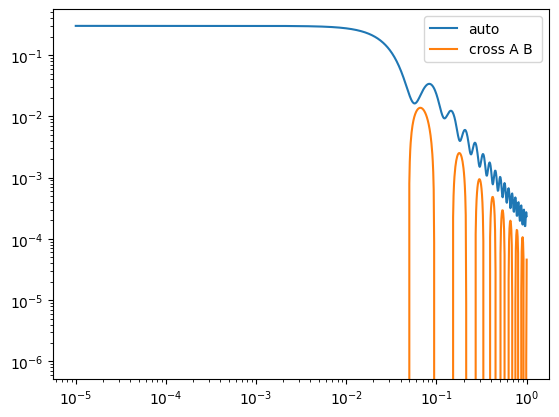

In [115]:
L = 2.5e9 # [m]
c = 3e8 # [m/s]
f_star = c/2/np.pi/L # [Hz]
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)
f_vec = np.logspace(-5, 0, 1000)
R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)

plt.loglog(f_vec, R1_vec, label='auto')
plt.loglog(f_vec, R2_vec, label='cross A B ')
plt.legend()


In [103]:
def Ylm(l,m,theta,phi):
    return spherharm(l,m,theta,phi)


In [104]:
Ylm(-2,2,0.1,0.1)

mpc(real='0.0', imag='0.0')

In [116]:
from scipy.special import sph_harm

def Ylm(l,m,theta,phi):
    return sph_harm(m,l,phi,theta)

def Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m):
    Theta_vec = np.linspace(0,np.pi,100)
    Phi_vec = np.linspace(0,2*np.pi,100)
    Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
    F1_p, F1_c = F_det(l_det1[0],l_det1[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det1)
    F2_p, F2_c = F_det(l_det2[0],l_det2[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det2)
    R_integrand_ell = (F1_p  * np.conj(F2_p) \
                + F1_c * np.conj(F2_c)) * Ylm(ell,m,Theta_mesh,Phi_mesh)*np.sqrt(4*np.pi)  #SPHERICAL HARMONIC redefined according to Eq. 4.2 paper LISA anisotropies
    R1 = np.trapz(R_integrand_ell,Phi_vec,axis=1)
    #Rellm = np.real(np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1))/4/np.pi
    Rellm = np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1)/4/np.pi
    return Rellm

In [117]:
# Verify the normalization
lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)
# R1 = Response(lA,lA,xA,xA,np.array([1e-5]),f_star)
# R2 = Response(lA,lB,xA,xB,np.array([1e-5]),f_star)

# print(R1/3*10)
# print(R2/(-3)*20)

f_vec = np.unique(np.concatenate((np.logspace(-5, -2, 10),np.linspace(1e-2,1e-1,60),np.linspace(1e-1, 1, 400))))

R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)

In [118]:
lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)
# R1 = Response(lA,lA,xA,xA,np.array([1e-5]),f_star)
# R2 = Response(lA,lB,xA,xB,np.array([1e-5]),f_star)

# print(R1/3*10)
# print(R2/(-3)*20)

f_vec = np.unique(np.concatenate((np.logspace(-5, -2, 10),np.linspace(1e-2,1e-1,60),np.linspace(1e-1, 1, 400))))

R1_vec_ell = Response_ell(lA,lA,xA,xA,f_vec,f_star, 0, 0)
R2_vec_ell = Response_ell(lA,lB,xA,xB,f_vec,f_star, 0, 0)

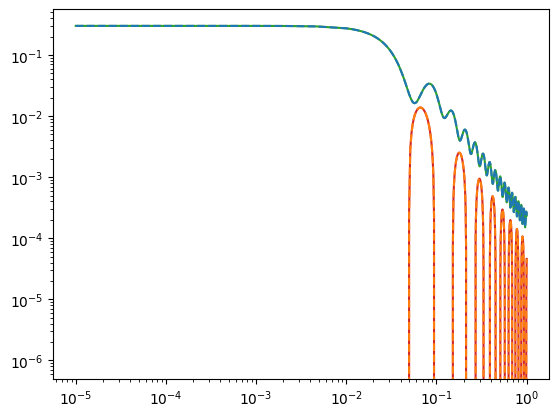

In [119]:
plt.loglog(f_vec,(R1_vec_ell),label='R l= 0 auto',c='C2')
plt.loglog(f_vec,(R2_vec_ell),label='R l= 0 cross',c='C3')
plt.loglog(f_vec,R1_vec,label='R auto',linestyle='--')
plt.loglog(f_vec,R2_vec,label='R cross',linestyle='--')

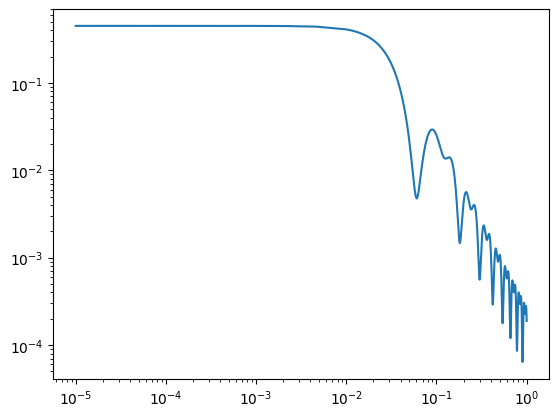

In [25]:
RAAell = R1_vec_ell - R2_vec_ell
plt.loglog(f_vec,(RAAell),label='RAA',c='C0')

In [120]:
def sum_m(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell):
    m = np.linspace(-ell,ell,2*ell+1)
    Rell = np.zeros_like(f_vec,dtype=complex)
    #Rell = np.zeros_like(f_vec)
    for i in range(len(m)):
        R = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i])
        #R2 = np.abs(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i]))**2
        Rstar = np.conj(R)
        Rell += R*Rstar
        #Rell += R2
    return np.sqrt(Rell)

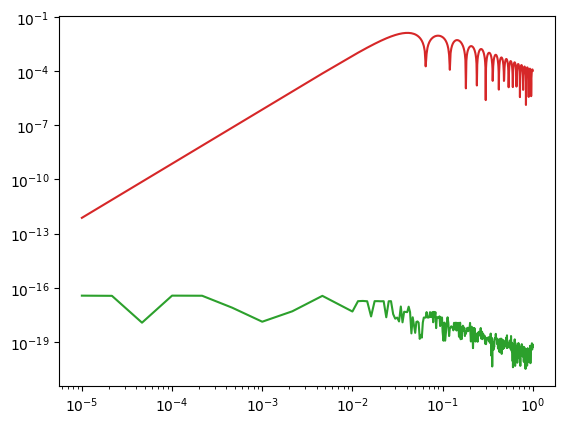

In [121]:
R11 = sum_m(lA,lA,xA,xA,f_vec,f_star,1)
R22 = sum_m(lA,lB,xA,xB,f_vec,f_star,1)
plt.loglog(f_vec,(R11),label='R11',c='C2')
plt.loglog(f_vec,(R22),label='R11',c='C3')

#plt.loglog(f_vec,(R2_vec),label='R2',c='C3')
#plt.loglog(f_vec,-(R2_vec),label='-R2',c='C3',linestyle='--')

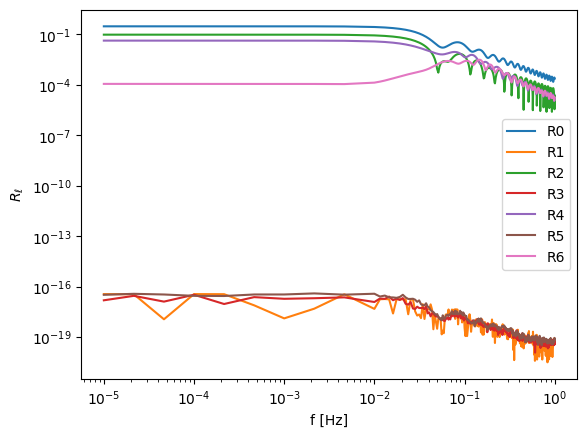

In [122]:
R0 = sum_m(lA,lA,xA,xA,f_vec,f_star,0)
R1 = sum_m(lA,lA,xA,xA,f_vec,f_star,1)
R2 = sum_m(lA,lB,xA,xB,f_vec,f_star,2)
R3 = sum_m(lA,lA,xA,xA,f_vec,f_star,3)
R4 = sum_m(lA,lB,xA,xB,f_vec,f_star,4)
R5 = sum_m(lA,lA,xA,xA,f_vec,f_star,5)
R6 = sum_m(lA,lB,xA,xB,f_vec,f_star,6)

# plot

plt.loglog(f_vec,(R0),label='R0',c='C0')
plt.loglog(f_vec,(R1),label='R1',c='C1')
plt.loglog(f_vec,(R2),label='R2',c='C2')
plt.loglog(f_vec,(R3),label='R3',c='C3')
plt.loglog(f_vec,(R4),label='R4',c='C4')
plt.loglog(f_vec,(R5),label='R5',c='C5')
plt.loglog(f_vec,(R6),label='R6',c='C6')
plt.xlabel('f [Hz]')
plt.ylabel(r'$R_{\ell}$')
plt.legend()


In [123]:
def sum_m_AET(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell):
    mvec = np.linspace(-ell,ell,2*ell+1)
    RlAA = np.zeros_like(f_vec,dtype=complex)
    RlTT = np.zeros_like(f_vec,dtype=complex)
    RlAE = np.zeros_like(f_vec,dtype=complex)
    RlAT = np.zeros_like(f_vec,dtype=complex)
    if int(ell)% 2 == 0:
        for m in mvec:
            R1 = Response_ell(l_det1,l_det1,x_det1,x_det1,f_vec,f_star,ell,m)
            R2 = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m)
            #RAA = 1/4*np.abs(1+np.exp(-4/3*1j*m[i]*np.pi)*(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i])))
            #RAE = 1/3*(1+2*np.cos(2*m[i]*np.pi/3))**2*np.abs(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i]))**2
            RlAA += np.abs((1+np.exp(-4j/3*m*np.pi)) * R1 - 2 * R2)**2
            RlTT += np.abs(R1 + 2*R2)**2*(1+2*np.cos(2*m*np.pi/3))**2 
            RlAE += (np.sin(m*np.pi/3))**2 * np.abs((1+np.exp(2j/3*m*np.pi))*R1 - 2 * R2)**2
            RlAT += (np.sin(m*np.pi/3))**2 * np.abs((1+np.exp(2j/3*m*np.pi))*R1 + R2)**2
            #Rell_rot += RAE
    else:  
        for m in mvec:
            R2 = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m)
            RlAE += (1+2*np.cos(2*m*np.pi/3))**2 * np.abs(R2)**2
            RlAT += (np.sin(m*np.pi/3)**2 * np.abs(R2)**2)*3
    return np.sqrt(np.real(RlAA)/4), np.sqrt(np.real(RlTT)/9), np.sqrt(np.real(RlAE)/3), np.sqrt(2*np.real(RlAT)/3)

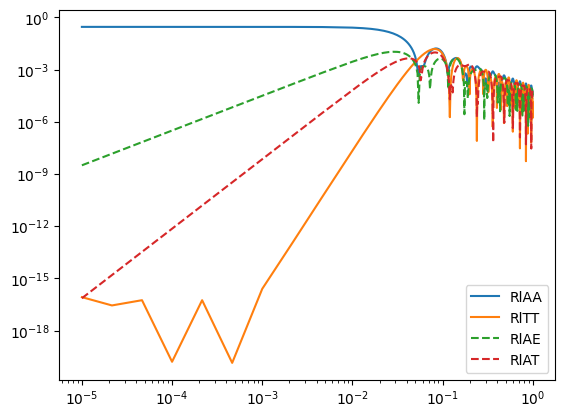

In [128]:
R = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,2)

plt.loglog(f_vec, R[0],label='RlAA',c='C0')
plt.loglog(f_vec,R[1],label='RlTT',c='C1')
plt.loglog(f_vec,R[2],label='RlAE',c='C2', linestyle='--')
plt.loglog(f_vec,R[3],label='RlAT',c='C3', linestyle='--')
plt.legend()




# plt.loglog(f_vec, R[2],label='RAA',c='C0')
# plt.ylim(1e-5,1e0)

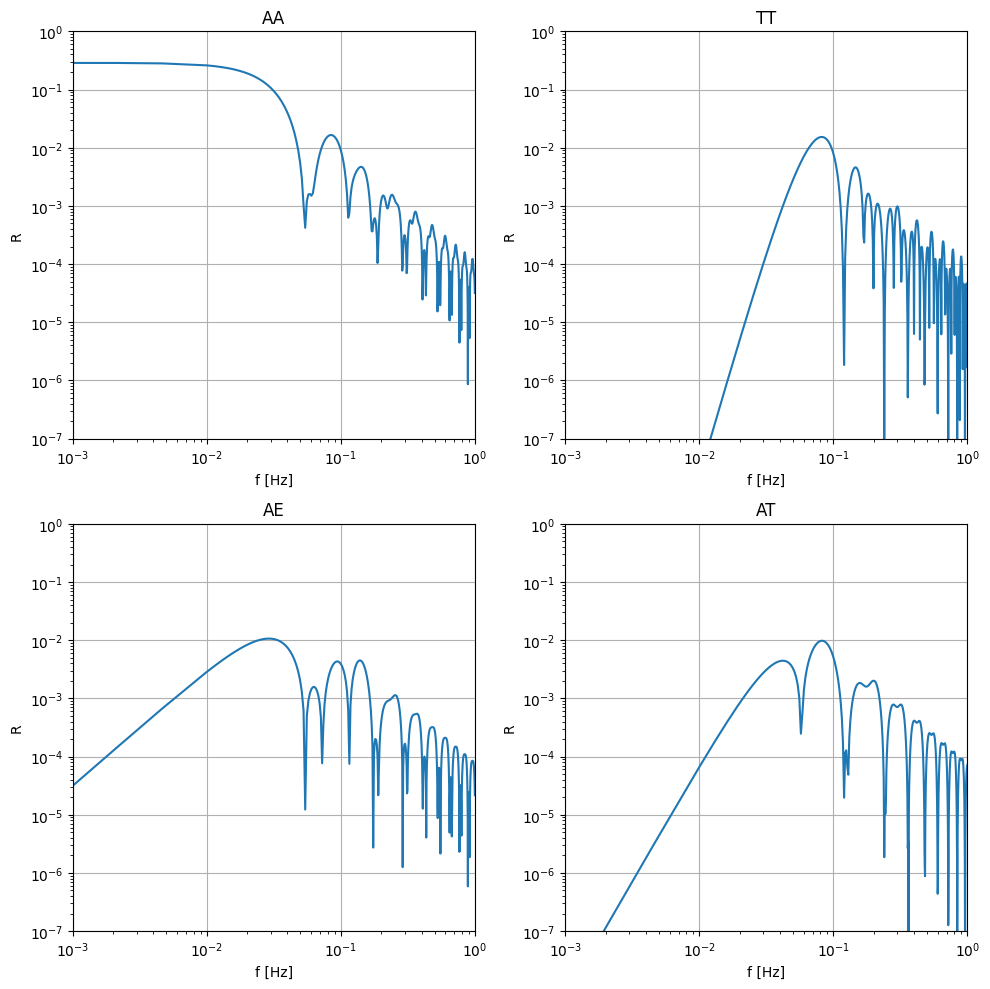

In [129]:
#f_vec = np.array([1e-3,1e-2])
l_value = 2
R = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,l_value)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax = axs.flatten()
for i, axis in enumerate(ax):
    axis.set_xlim(1e-3, 1)
    axis.set_ylim(1e-7, 1)
    axis.set_title(['AA','TT','AE','AT'][i])
    axis.loglog(f_vec, R[i])
    axis.set_xlabel('f [Hz]')
    axis.set_ylabel('R')
    axis.grid()
plt.tight_layout()
plt.show()

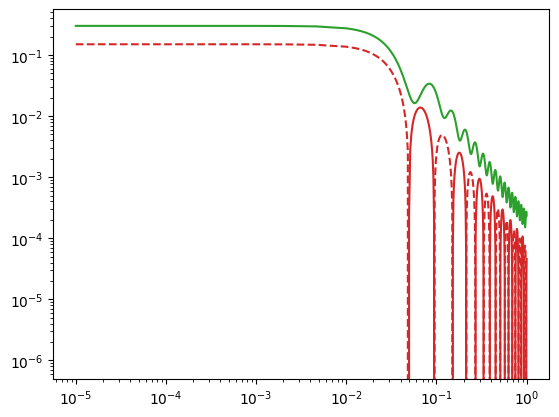

In [33]:
plt.loglog(f_vec,(R1_vec),label='R1',c='C2')
plt.loglog(f_vec,(R2_vec),label='R2',c='C3')
plt.loglog(f_vec,-(R2_vec),label='-R2',c='C3',linestyle='--')

In [34]:
RAA = R1_vec - R2_vec
RTT = R1_vec + 2*R2_vec

(1e-05, 1)

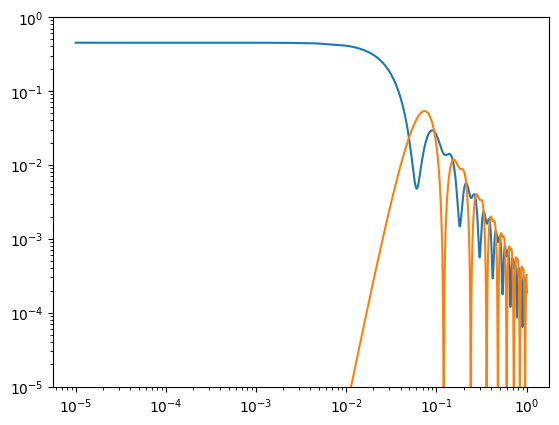

In [35]:
plt.plot(f_vec,RAA)
plt.plot(f_vec,RTT)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5,1)